In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os.path
import datetime
import matplotlib.image as mpimg



def get_points_for_warp_operation(img_size):
    src = np.float32(
        [[(img_size[1] / 2) - 55 - 2, img_size[0] / 2 + 100], 
        [((img_size[1] / 6) - 10), img_size[0]], 
        [(img_size[1] * 5 / 6) + 35, img_size[0]], 
        [(img_size[1] / 2 + 55 + 6), img_size[0] / 2 + 100]])
    dst = np.float32(
        [[(img_size[1] / 4), 0], 
        [(img_size[1] / 4), img_size[0]], 
        [(img_size[1] * 3 / 4), img_size[0]], 
        [(img_size[1] * 3 / 4), 0]])
    return src,dst


def make_mask_image(img):

    ret=img.copy()
    if os.path.exists('./areamask.jpg')==False:
        ystart=400
        yend=656
        x=img.shape[1]//2
        ys=ystart
        ye=yend
        mask=img.copy()
        mask*=0
        area=mask.copy()
        maskR=mask.copy()
        maskG=mask.copy()
        maskB=mask.copy()

        left = np.array( [ [0,ys-50], [0,ye] ,  [x-250,ye]  , [x,ys] ] )
        maskR=cv2.fillPoly(maskR, pts =[left], color=(255,0,0))

        mid = np.array( [ [x,ys], [x-250,ys+50], [x-450,ye]        ,[x+450,ye]  , [x+250,ys+50] ] )
        maskG=cv2.fillPoly(maskG, pts =[mid], color=(0,255,0))

        right = np.array( [[area.shape[1],ys-50], [area.shape[1],ye] ,[x+250,ye]  , [x,ys] ] )
        maskB=cv2.fillPoly(maskB, pts =[right], color=(0,0,255))


        mask=cv2.bitwise_or(maskR,maskG)
        mask=cv2.bitwise_or(mask ,maskB)

        cv2.imwrite('./areamask.jpg',mask)
        ret= mask.copy()
    else:
        mask= mpimg.imread('./areamask.jpg')
        ret= mask.copy()
    
    
    return ret

def get_approximation_lanewidth(img,Y):
    src,dst=get_points_for_warp_operation(img.shape)
    debug=img.copy()
    pt1=[src[0],src[1]]
    pt2=[src[2],src[3]]
    
    #debug=cv2.line(debug,tuple(pt1[0]) ,tuple(pt1[1]), (0, 0, 255), 2)
    #debug=cv2.line(debug,tuple(pt2[0]) ,tuple(pt2[1]), (0, 0, 255), 2)
    #plt.imshow(debug)
    #plt.show()
    
    ##############
    ##    x1-x2
    ##x=--------(y-y1)+x1  
    ##   y1-y2
    
    A1=(pt1[0][0]-pt1[1][0])/(pt1[0][1]-pt1[1][1])
    B1=-A1*pt1[0][1]+pt1[0][0]
    
    A2=(pt2[0][0]-pt2[1][0])/(pt2[0][1]-pt2[1][1])
    B2=-A2*pt2[0][1]+pt2[0][0]
    
    ## x1=A1･y+B1
    ## x2=A2･y+B2
    ##  w=x2-x1 = (A2-A1)y+ B2-B1
    W =np.int((A2-A1)*Y+ B2-B1)
    X1=np.int(A1*Y+B1)
    X2=np.int(A2*Y+B2)
    
    B=np.int(W*2.2/3.7)
    #Bは予測される車幅
    
    return W, X1,X2 ,B 
    
    




In [7]:

def process_image(img):

    mask=make_mask_image(img)

    area=mask.copy()
    area*=0
    area = cv2.addWeighted(img, 0.6, mask, 0.4,1)   
    
    return area


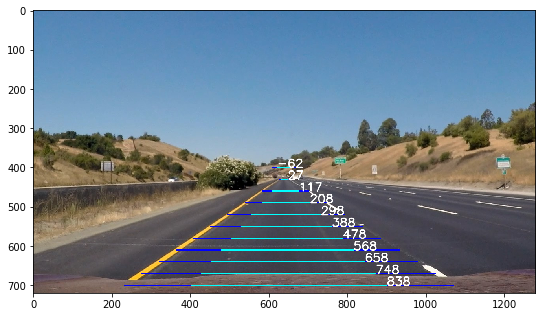

In [15]:

img= mpimg.imread('./straight_lines1.jpg')
ret=img.copy()
plt.figure(figsize=(9,6))
#plt.imshow(process_image(img))

for y in range( 400,img.shape[0],30 ):
    W,X1,X2,B = get_approximation_lanewidth(img,y)
    p1=(X1,y)
    p2=(X2,y)
    p3=(X1+W,y)
    img=cv2.line(img,p1,p2, (0, 0, 255), 2)
    ps=((X1+X2)//2-B//2,y)
    pe=((X1+X2)//2+B//2,y)
    
    img=cv2.line(img,ps,pe, (0, 255, 255), 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,str(W),pe, font, 1,(255,255,255),2,cv2.LINE_AA)

plt.imshow(img)    
plt.show()

In [9]:
prj_output = 'videos_output/project_test.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

#clip1  = VideoFileClip("./project_video.mp4").subclip(0,5)
clip1  = VideoFileClip("./project_video.mp4")


#white_clip  =  clip1.fl_image(test_image) #NOTE: this function expects color images!!
white_clip  =  clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(prj_output, audio=False)

[MoviePy] >>>> Building video videos_output/project_test.mp4
[MoviePy] Writing video videos_output/project_test.mp4


100%|█████████▉| 1260/1261 [01:50<00:00, 11.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_output/project_test.mp4 

CPU times: user 59.4 s, sys: 11.1 s, total: 1min 10s
Wall time: 1min 53s


In [10]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(prj_output))

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os.path
import datetime
import matplotlib.image as mpimg
import glob

images = glob.glob('./test_images/test*.png')
for fname in images:
        print(fname)
        img = cv2.imread(fname)
        
        rev= cv2.flip(img, 1)
        txt=fname.replace('_images/test','_images/rev')
        print(txt)
        cv2.imwrite(txt,rev)
    

./test_images/test2.png
./test_images/rev2.png
./test_images/test4.png
./test_images/rev4.png
./test_images/test6.png
./test_images/rev6.png
./test_images/test1.png
./test_images/rev1.png
./test_images/test3.png
./test_images/rev3.png
./test_images/test5.png
./test_images/rev5.png


In [31]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os.path
import datetime
import matplotlib.image as mpimg
import glob


##images = glob.glob('./vehicles/vehicles/GTI_LeftfromR/image*.png')
images = glob.glob('./vehicles/vehicles/GTI_RightfromL/image*.png')

print(len(images))
for fname in images:
        print(fname)
        img = cv2.imread(fname)
        
        rev= cv2.flip(img, 1)
        #txt=fname.replace('GTI_LeftFromR/','GTI_LeftfromR/rev/')
        txt=fname.replace('GTI_LeftFromR/','GTI_LeftfromR/rev/')
        
        cv2.imwrite(fname,rev)
    

664
./vehicles/vehicles/GTI_LeftfromR/image0599.png
./vehicles/vehicles/GTI_LeftfromR/image0548.png
./vehicles/vehicles/GTI_LeftfromR/image0624.png
./vehicles/vehicles/GTI_LeftfromR/image0481.png
./vehicles/vehicles/GTI_LeftfromR/image0118.png
./vehicles/vehicles/GTI_LeftfromR/image0170.png
./vehicles/vehicles/GTI_LeftfromR/image0602.png
./vehicles/vehicles/GTI_LeftfromR/image0319.png
./vehicles/vehicles/GTI_LeftfromR/image0351.png
./vehicles/vehicles/GTI_LeftfromR/image0875.png
./vehicles/vehicles/GTI_LeftfromR/image0532.png
./vehicles/vehicles/GTI_LeftfromR/image0260.png
./vehicles/vehicles/GTI_LeftfromR/image0251.png
./vehicles/vehicles/GTI_LeftfromR/image0759.png
./vehicles/vehicles/GTI_LeftfromR/image0814.png
./vehicles/vehicles/GTI_LeftfromR/image0706.png
./vehicles/vehicles/GTI_LeftfromR/image0649.png
./vehicles/vehicles/GTI_LeftfromR/image0583.png
./vehicles/vehicles/GTI_LeftfromR/image0505.png
./vehicles/vehicles/GTI_LeftfromR/image0160.png
./vehicles/vehicles/GTI_LeftfromR/im

./vehicles/vehicles/GTI_LeftfromR/image0936.png
./vehicles/vehicles/GTI_LeftfromR/image0744.png
./vehicles/vehicles/GTI_LeftfromR/image0753.png
./vehicles/vehicles/GTI_LeftfromR/image0646.png
./vehicles/vehicles/GTI_LeftfromR/image0197.png
./vehicles/vehicles/GTI_LeftfromR/image0637.png
./vehicles/vehicles/GTI_LeftfromR/image0308.png
./vehicles/vehicles/GTI_LeftfromR/image0174.png
./vehicles/vehicles/GTI_LeftfromR/image0671.png
./vehicles/vehicles/GTI_LeftfromR/image0502.png
./vehicles/vehicles/GTI_LeftfromR/image0774.png
./vehicles/vehicles/GTI_LeftfromR/image0973.png
./vehicles/vehicles/GTI_LeftfromR/image0218.png
./vehicles/vehicles/GTI_LeftfromR/image0591.png
./vehicles/vehicles/GTI_LeftfromR/image0289.png
./vehicles/vehicles/GTI_LeftfromR/image0357.png
./vehicles/vehicles/GTI_LeftfromR/image0559.png
./vehicles/vehicles/GTI_LeftfromR/image0457.png
./vehicles/vehicles/GTI_LeftfromR/image0128.png
./vehicles/vehicles/GTI_LeftfromR/image0605.png
./vehicles/vehicles/GTI_LeftfromR/image0

./vehicles/vehicles/GTI_LeftfromR/image0305.png
./vehicles/vehicles/GTI_LeftfromR/image0563.png
./vehicles/vehicles/GTI_LeftfromR/image0696.png
./vehicles/vehicles/GTI_LeftfromR/image0161.png
./vehicles/vehicles/GTI_LeftfromR/image0224.png
./vehicles/vehicles/GTI_LeftfromR/image0618.png
./vehicles/vehicles/GTI_LeftfromR/image0196.png
./vehicles/vehicles/GTI_LeftfromR/image0440.png
./vehicles/vehicles/GTI_LeftfromR/image0854.png
./vehicles/vehicles/GTI_LeftfromR/image0286.png
./vehicles/vehicles/GTI_LeftfromR/image0844.png
./vehicles/vehicles/GTI_LeftfromR/image0937.png
./vehicles/vehicles/GTI_LeftfromR/image0533.png
./vehicles/vehicles/GTI_LeftfromR/image0296.png
./vehicles/vehicles/GTI_LeftfromR/image0173.png
./vehicles/vehicles/GTI_LeftfromR/image0211.png
./vehicles/vehicles/GTI_LeftfromR/image0329.png
./vehicles/vehicles/GTI_LeftfromR/image0825.png
./vehicles/vehicles/GTI_LeftfromR/image0323.png
./vehicles/vehicles/GTI_LeftfromR/image0547.png
./vehicles/vehicles/GTI_LeftfromR/image0